In [1]:
from sea_breeze import load_model_data, utils
import xarray as xr
from dask.distributed import Client
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import hvplot.xarray
import numpy as np
import logging

logging.getLogger("flox").setLevel(logging.WARNING)

In [3]:
def load(model,diagnostic,chunks={"time":10}):

    ds = xr.open_mfdataset("/g/data/ng72/ab4502/sea_breeze_detection/"+\
                      model+\
                      "/filters/filtered_mask_no_hourly_change_"+\
                      diagnostic+\
                      "_*.zarr/",
                 chunks=chunks, engine="zarr")   
    
    return ds

def count_num_of_objs(da):
    x = np.unique(da)
    x = x[x!=0]
    x = x[~np.isnan(x)]
    return len(x)

def mask(ds,angle_ds,orog,mask=True,mask_thresh=0.5,orog_thresh=500):
    return xr.where(
        (angle_ds.variance_interp<mask_thresh) & (orog<orog_thresh),
        ds, np.nan)    

In [4]:
Client()

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.07/lib/python3.10/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 43435 instead
  warnings.warn(


<Client: 'tcp://127.0.0.1:41621' processes=7 threads=14, memory=63.00 GiB>

In [5]:
angle_list = []
models = ["aus2200","barra_c","barra_r","era5"]
for m in models:
    angle_ds = load_model_data.get_coastline_angle_kernel(
        compute=False,
        path_to_load="/g/data/ng72/ab4502/coastline_data/"+m+".nc",
        lat_slice=slice(-45.7,-6.9),
        lon_slice=slice(108,158.5)
    )
    angle_list.append(angle_ds)

In [6]:
models = ["aus2200_smooth_s4","barra_c_smooth_s2","barra_r","era5"]
chunks = [{"time":50},{"time":100},{"time":-1},{"time":-1}]

# Fc_list = []
# for m,c in zip(models,chunks):
#     print(m)
#     temp = load(m,"Fc",chunks=c)
#     Fc_list.append(
#         temp
#     )

F_list = []
for m,c in zip(models,chunks):
    print(m)
    temp = load(m,"F",chunks=c)
    F_list.append(
        temp
    )    

fuzzy_list = []
for m,c in zip(models,chunks):
    print(m)
    temp = load(m,"fuzzy",chunks=c)
    fuzzy_list.append(
        temp
    )


models = ["aus2200_smooth_s4","era5"]
chunks = [{"time":50},{"time":-1}]

sbi_list = []
for m,c in zip(models,chunks):
    print(m)
    temp = load(m,"sbi",chunks=c)
    sbi_list.append(
        temp
    )

aus2200_smooth_s4
barra_c_smooth_s2
barra_r
era5
aus2200_smooth_s4
barra_c_smooth_s2
barra_r
era5
aus2200_smooth_s4
era5


In [7]:
perth_lat, perth_lon = utils.get_perth_bounds()
darwin_lat, darwin_lon = utils.get_darwin_large_bounds()
gipps_lat,gipps_lon = utils.get_gippsland_bounds()
large_perth_lat, large_perth_lon = utils.get_perth_large_bounds()
aus_lat, aus_lon = utils.get_aus_bounds()
seaus_lat, seaus_lon = utils.get_seaus_bounds()

In [8]:
lat_slice=slice(-45.7,-6.9)
lon_slice=slice(108,158.5)
aus2200_orog, aus2200_lsm = load_model_data.load_aus2200_static("mjo-elnino2016",lon_slice,lat_slice)
barra_c_orog, barra_c_lsm = load_model_data.load_barra_static("AUST-04",lon_slice, lat_slice)
barra_r_orog, barra_r_lsm = load_model_data.load_barra_static("AUS-11",lon_slice, lat_slice)
era5_orog, era5_lsm, _ = load_model_data.load_era5_static(lon_slice, lat_slice, "2016-01-01", "2016-01-01")

orog_list = [aus2200_orog,barra_c_orog,barra_r_orog,era5_orog/9.8]

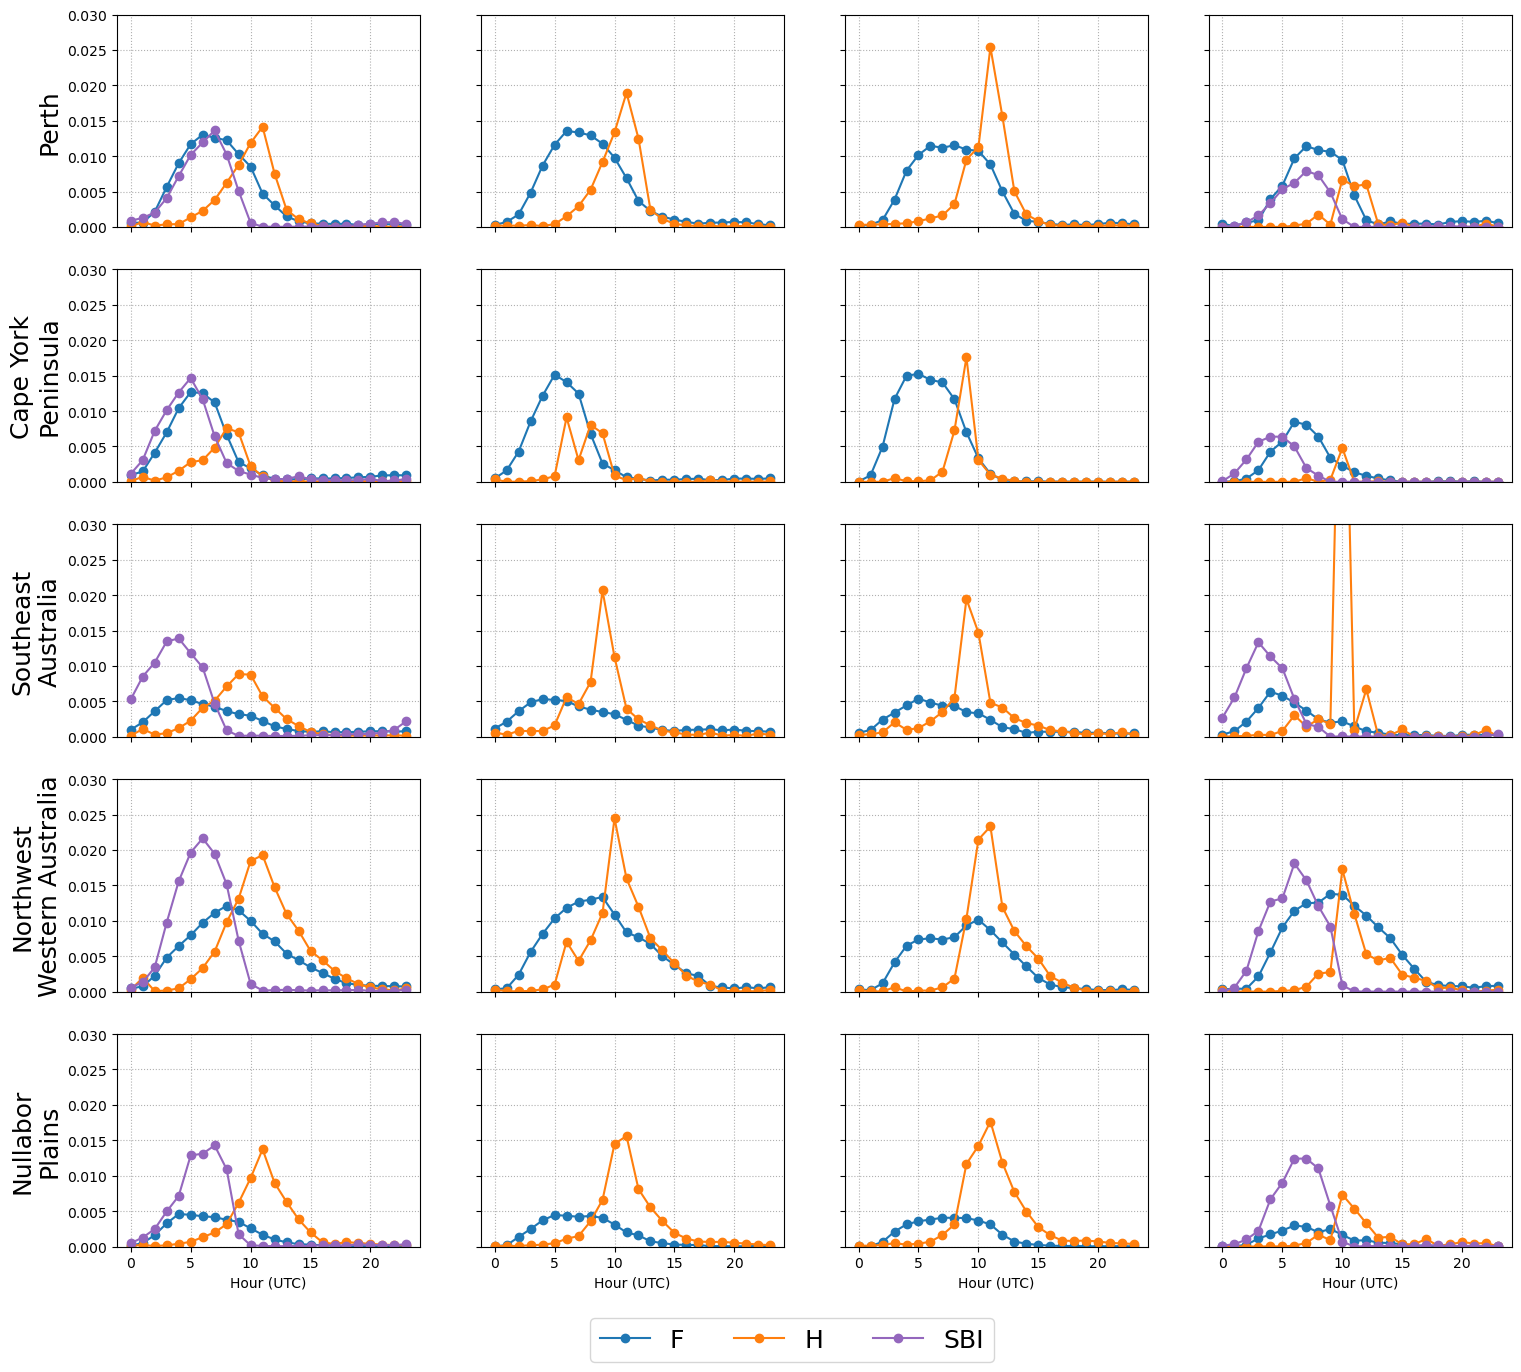

In [51]:
def plot(ax, da, lat_slice, lon_slice, angle_ds, orog, label="", color=None, ymax=None, yticklabels=False, xticklabels=False,ylabel=""):

    mask(
        da.mask.sel(lat=lat_slice,lon=lon_slice),
        angle_ds.sel(lat=lat_slice,lon=lon_slice),
        orog.sel(lat=lat_slice,lon=lon_slice)).mean(("lat","lon")).groupby("time.hour").mean().plot(
        label=label,color=color,marker="o",ax=ax)    
    plt.title("")
    ax.grid(ls=":")
    if ymax is not None:
        ax.set_ylim([0,ymax])
    if yticklabels:
        ax.set_ylabel(ylabel,size=18)
    else:
        ax.set_yticklabels([])
    if xticklabels:
        ax.set_xlabel("Hour (UTC)")
    else:
        ax.set_xticklabels([])    
        ax.set_xlabel("")

fig=plt.figure(figsize=[18,16])


#########
# Perth #
#########

lat_slice = slice(-36,-30)
lon_slice = slice(113,119)
ymax=0.03

ax=plt.subplot(5,4,1)
plot(ax,F_list[0],lat_slice,lon_slice,angle_list[0],orog_list[0],color="tab:blue",ymax=ymax,yticklabels=True)
plot(ax,fuzzy_list[0],lat_slice,lon_slice,angle_list[0],orog_list[0],color="tab:orange",ymax=ymax,yticklabels=True)
plot(ax,sbi_list[0],lat_slice,lon_slice,angle_list[0],orog_list[0],color="tab:purple",ymax=ymax,yticklabels=True,ylabel="Perth")

ax=plt.subplot(5,4,2)
plot(ax,F_list[1],lat_slice,lon_slice,angle_list[1],orog_list[1],color="tab:blue",ymax=ymax)
plot(ax,fuzzy_list[1],lat_slice,lon_slice,angle_list[1],orog_list[1],color="tab:orange",ymax=ymax)

ax=plt.subplot(5,4,3)
plot(ax,F_list[2],lat_slice,lon_slice,angle_list[2],orog_list[2],color="tab:blue",ymax=ymax)
plot(ax,fuzzy_list[2],lat_slice,lon_slice,angle_list[2],orog_list[2],color="tab:orange",ymax=ymax)

ax=plt.subplot(5,4,4)
plot(ax,F_list[3],lat_slice,lon_slice,angle_list[3],orog_list[3],color="tab:blue",ymax=ymax)
plot(ax,fuzzy_list[3],lat_slice,lon_slice,angle_list[3],orog_list[3],color="tab:orange",ymax=ymax)
plot(ax,sbi_list[1],lat_slice,lon_slice,angle_list[3],orog_list[3],color="tab:purple",ymax=ymax)



#######################
# Cape York Peninsula #
#######################

lat_slice = slice(-16.5,-10.5)
lon_slice = slice(140,146)
ymax=0.03

ax=plt.subplot(5,4,5)
plot(ax,F_list[0],lat_slice,lon_slice,angle_list[0],orog_list[0],color="tab:blue",ymax=ymax,yticklabels=True)
plot(ax,fuzzy_list[0],lat_slice,lon_slice,angle_list[0],orog_list[0],color="tab:orange",ymax=ymax,yticklabels=True)
plot(ax,sbi_list[0],lat_slice,lon_slice,angle_list[0],orog_list[0],color="tab:purple",ymax=ymax,yticklabels=True,ylabel="Cape York\nPeninsula")

ax=plt.subplot(5,4,6)
plot(ax,F_list[1],lat_slice,lon_slice,angle_list[1],orog_list[1],color="tab:blue",ymax=ymax)
plot(ax,fuzzy_list[1],lat_slice,lon_slice,angle_list[1],orog_list[1],color="tab:orange",ymax=ymax)

ax=plt.subplot(5,4,7)
plot(ax,F_list[2],lat_slice,lon_slice,angle_list[2],orog_list[2],color="tab:blue",ymax=ymax)
plot(ax,fuzzy_list[2],lat_slice,lon_slice,angle_list[2],orog_list[2],color="tab:orange",ymax=ymax)

ax=plt.subplot(5,4,8)
plot(ax,F_list[3],lat_slice,lon_slice,angle_list[3],orog_list[3],color="tab:blue",ymax=ymax)
plot(ax,fuzzy_list[3],lat_slice,lon_slice,angle_list[3],orog_list[3],color="tab:orange",ymax=ymax)
plot(ax,sbi_list[1],lat_slice,lon_slice,angle_list[3],orog_list[3],color="tab:purple",ymax=ymax)


###########################
# South eastern Australia #
###########################

lat_slice = slice(-40,-31)
lon_slice = slice(143.1,152.1)
ymax=0.03

ax=plt.subplot(5,4,9)
plot(ax,F_list[0],lat_slice,lon_slice,angle_list[0],orog_list[0],color="tab:blue",ymax=ymax,yticklabels=True)
plot(ax,fuzzy_list[0],lat_slice,lon_slice,angle_list[0],orog_list[0],color="tab:orange",ymax=ymax,yticklabels=True)
plot(ax,sbi_list[0],lat_slice,lon_slice,angle_list[0],orog_list[0],color="tab:purple",ymax=ymax,yticklabels=True,ylabel="Southeast\nAustralia")

ax=plt.subplot(5,4,10)
plot(ax,F_list[1],lat_slice,lon_slice,angle_list[1],orog_list[1],color="tab:blue",ymax=ymax)
plot(ax,fuzzy_list[1],lat_slice,lon_slice,angle_list[1],orog_list[1],color="tab:orange",ymax=ymax)

ax=plt.subplot(5,4,11)
plot(ax,F_list[2],lat_slice,lon_slice,angle_list[2],orog_list[2],color="tab:blue",ymax=ymax)
plot(ax,fuzzy_list[2],lat_slice,lon_slice,angle_list[2],orog_list[2],color="tab:orange",ymax=ymax)

ax=plt.subplot(5,4,12)
plot(ax,F_list[3],lat_slice,lon_slice,angle_list[3],orog_list[3],color="tab:blue",ymax=ymax)
plot(ax,fuzzy_list[3],lat_slice,lon_slice,angle_list[3],orog_list[3],color="tab:orange",ymax=ymax)
plot(ax,sbi_list[1],lat_slice,lon_slice,angle_list[3],orog_list[3],color="tab:purple",ymax=ymax)


###########################
# Northwest Western Aus   #
###########################

lat_slice = slice(-24.1,-14.1)
lon_slice = slice(118,128)
ymax=0.03

ax=plt.subplot(5,4,13)
plot(ax,F_list[0],lat_slice,lon_slice,angle_list[0],orog_list[0],color="tab:blue",ymax=ymax,yticklabels=True)
plot(ax,fuzzy_list[0],lat_slice,lon_slice,angle_list[0],orog_list[0],color="tab:orange",ymax=ymax,yticklabels=True)
plot(ax,sbi_list[0],lat_slice,lon_slice,angle_list[0],orog_list[0],color="tab:purple",ymax=ymax,yticklabels=True,ylabel="Northwest\nWestern Australia")

ax=plt.subplot(5,4,14)
plot(ax,F_list[1],lat_slice,lon_slice,angle_list[1],orog_list[1],color="tab:blue",ymax=ymax)
plot(ax,fuzzy_list[1],lat_slice,lon_slice,angle_list[1],orog_list[1],color="tab:orange",ymax=ymax)

ax=plt.subplot(5,4,15)
plot(ax,F_list[2],lat_slice,lon_slice,angle_list[2],orog_list[2],color="tab:blue",ymax=ymax)
plot(ax,fuzzy_list[2],lat_slice,lon_slice,angle_list[2],orog_list[2],color="tab:orange",ymax=ymax)

ax=plt.subplot(5,4,16)
plot(ax,F_list[3],lat_slice,lon_slice,angle_list[3],orog_list[3],color="tab:blue",ymax=ymax)
plot(ax,fuzzy_list[3],lat_slice,lon_slice,angle_list[3],orog_list[3],color="tab:orange",ymax=ymax)
plot(ax,sbi_list[1],lat_slice,lon_slice,angle_list[3],orog_list[3],color="tab:purple",ymax=ymax)


####################
# Nullabor Plains  #
####################

lat_slice = slice(-38,-28)
lon_slice = slice(120,130)
ymax=0.03

ax=plt.subplot(5,4,17)
plot(ax,F_list[0],lat_slice,lon_slice,angle_list[0],orog_list[0],label="",color="tab:blue",ymax=ymax,yticklabels=True,xticklabels=True)
plot(ax,fuzzy_list[0],lat_slice,lon_slice,angle_list[0],orog_list[0],label="",color="tab:orange",ymax=ymax,yticklabels=True,xticklabels=True)
plot(ax,sbi_list[0],lat_slice,lon_slice,angle_list[0],orog_list[0],label="",color="tab:purple",ymax=ymax,yticklabels=True,xticklabels=True,ylabel="Nullabor\nPlains")

ax=plt.subplot(5,4,18)
plot(ax,F_list[1],lat_slice,lon_slice,angle_list[1],orog_list[1],label="",color="tab:blue",ymax=ymax,xticklabels=True)
plot(ax,fuzzy_list[1],lat_slice,lon_slice,angle_list[1],orog_list[1],label="",color="tab:orange",ymax=ymax,xticklabels=True)

ax=plt.subplot(5,4,19)
plot(ax,F_list[2],lat_slice,lon_slice,angle_list[2],orog_list[2],label="",color="tab:blue",ymax=ymax,xticklabels=True)
plot(ax,fuzzy_list[2],lat_slice,lon_slice,angle_list[2],orog_list[2],label="",color="tab:orange",ymax=ymax,xticklabels=True)

ax=plt.subplot(5,4,20)
plot(ax,F_list[3],lat_slice,lon_slice,angle_list[3],orog_list[3],label="F",color="tab:blue",ymax=ymax,xticklabels=True)
plot(ax,fuzzy_list[3],lat_slice,lon_slice,angle_list[3],orog_list[3],label="H",color="tab:orange",ymax=ymax,xticklabels=True)
plot(ax,sbi_list[1],lat_slice,lon_slice,angle_list[3],orog_list[3],label="SBI",color="tab:purple",ymax=ymax,xticklabels=True)

fig.legend(loc="lower center",bbox_to_anchor=(0.5,0.03),ncols=6,fontsize=18)

plt.savefig("/g/data/ng72/ab4502/figs/methods_paper/diurnal_counts.jpeg",bbox_inches="tight",dpi=500)

In [59]:
print("Print values for ERA5 using the fuzzy algorithm, over SE Aus")
lat_slice = slice(-40,-31)
lon_slice = slice(143.1,152.1)
mask(
    fuzzy_list[3].mask.sel(lat=lat_slice,lon=lon_slice),
    angle_list[3].sel(lat=lat_slice,lon=lon_slice),
    orog_list[3].sel(lat=lat_slice,lon=lon_slice)).mean(("lat","lon")).groupby("time.hour").mean().to_dataframe(name="Mean").sort_values("Mean",ascending=False)

Print values for ERA5 using the fuzzy algorithm, over SE Aus


Mean
hour          
10    0.075238
12    0.006694
6     0.003024
8     0.002466
9     0.001826
7     0.001431
15    0.001035
22    0.001000
11    0.000994
5     0.000820
3     0.000279
4     0.000238
14    0.000204
21    0.000198
13    0.000128
2     0.000116
18    0.000093
20    0.000076
1     0.000058
17    0.000035
19    0.000012
0     0.000000
16    0.000000
23    0.000000

# Diurnal timing of sea breeze objects at each grid point (Frontogenesis only)

Text(0.5, 1.0, '12 UTC')

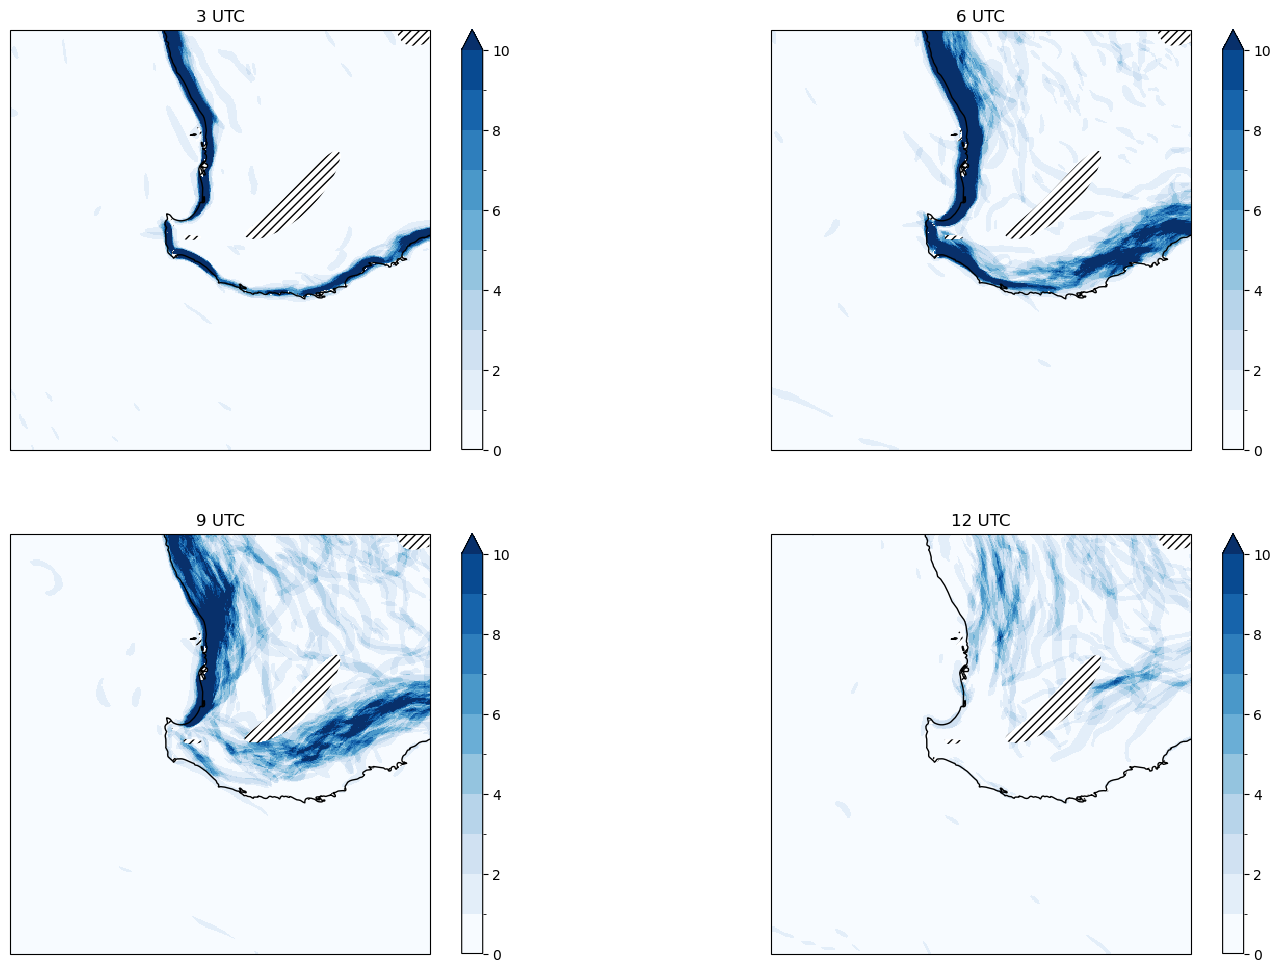

In [37]:
plt.figure(figsize=[18,12])

lat_slice=large_perth_lat
lon_slice=large_perth_lon
orog, lsm = load_model_data.load_aus2200_static("mjo-elnino2016",lon_slice,lat_slice)

ax=plt.subplot(2,2,1,projection=ccrs.PlateCarree())
mask(
    F_list[0].mask.sel(lat=lat_slice,lon=lon_slice,time=F_list[0].time.dt.hour==3).sum("time"),
    angle_list[0].sel(lat=lat_slice,lon=lon_slice)).plot(cmap="Blues",levels=np.linspace(0,10,11))
ax.coastlines()
xr.plot.contourf(angle_list[0].sel(lat=lat_slice,lon=lon_slice).variance_interp,levels=[0.,0.5],hatches=["","////"],colors="none",add_colorbar=False)
xr.plot.contour(orog,levels=[600,1200],colors=["grey","grey"],linewidths=0.5)
plt.title("3 UTC")

ax=plt.subplot(2,2,2,projection=ccrs.PlateCarree())
mask(
    F_list[0].mask.sel(lat=lat_slice,lon=lon_slice,time=F_list[0].time.dt.hour==6).sum("time"),
    angle_list[0].sel(lat=lat_slice,lon=lon_slice)).plot(cmap="Blues",levels=np.linspace(0,10,11))
ax.coastlines()
xr.plot.contourf(angle_list[0].sel(lat=lat_slice,lon=lon_slice).variance_interp,levels=[0.,0.5],hatches=["","////"],colors="none",add_colorbar=False)
xr.plot.contour(orog,levels=[600,1200],colors=["grey","grey"],linewidths=0.5)
plt.title("6 UTC")

ax=plt.subplot(2,2,3,projection=ccrs.PlateCarree())
mask(
    F_list[0].mask.sel(lat=lat_slice,lon=lon_slice,time=F_list[0].time.dt.hour==9).sum("time"),
    angle_list[0].sel(lat=lat_slice,lon=lon_slice)).plot(cmap="Blues",levels=np.linspace(0,10,11))
ax.coastlines()
xr.plot.contourf(angle_list[0].sel(lat=lat_slice,lon=lon_slice).variance_interp,levels=[0.,0.5],hatches=["","////"],colors="none",add_colorbar=False)
xr.plot.contour(orog,levels=[600,1200],colors=["grey","grey"],linewidths=0.5)
plt.title("9 UTC")

ax=plt.subplot(2,2,4,projection=ccrs.PlateCarree())
mask(
    F_list[0].mask.sel(lat=lat_slice,lon=lon_slice,time=F_list[0].time.dt.hour==12).sum("time"),
    angle_list[0].sel(lat=lat_slice,lon=lon_slice)).plot(cmap="Blues",levels=np.linspace(0,10,11))
ax.coastlines()
xr.plot.contourf(angle_list[0].sel(lat=lat_slice,lon=lon_slice).variance_interp,levels=[0.,0.5],hatches=["","////"],colors="none",add_colorbar=False)
xr.plot.contour(orog,levels=[600,1200],colors=["grey","grey"],linewidths=0.5)
plt.title("12 UTC")

Text(0.5, 1.0, '12 UTC')

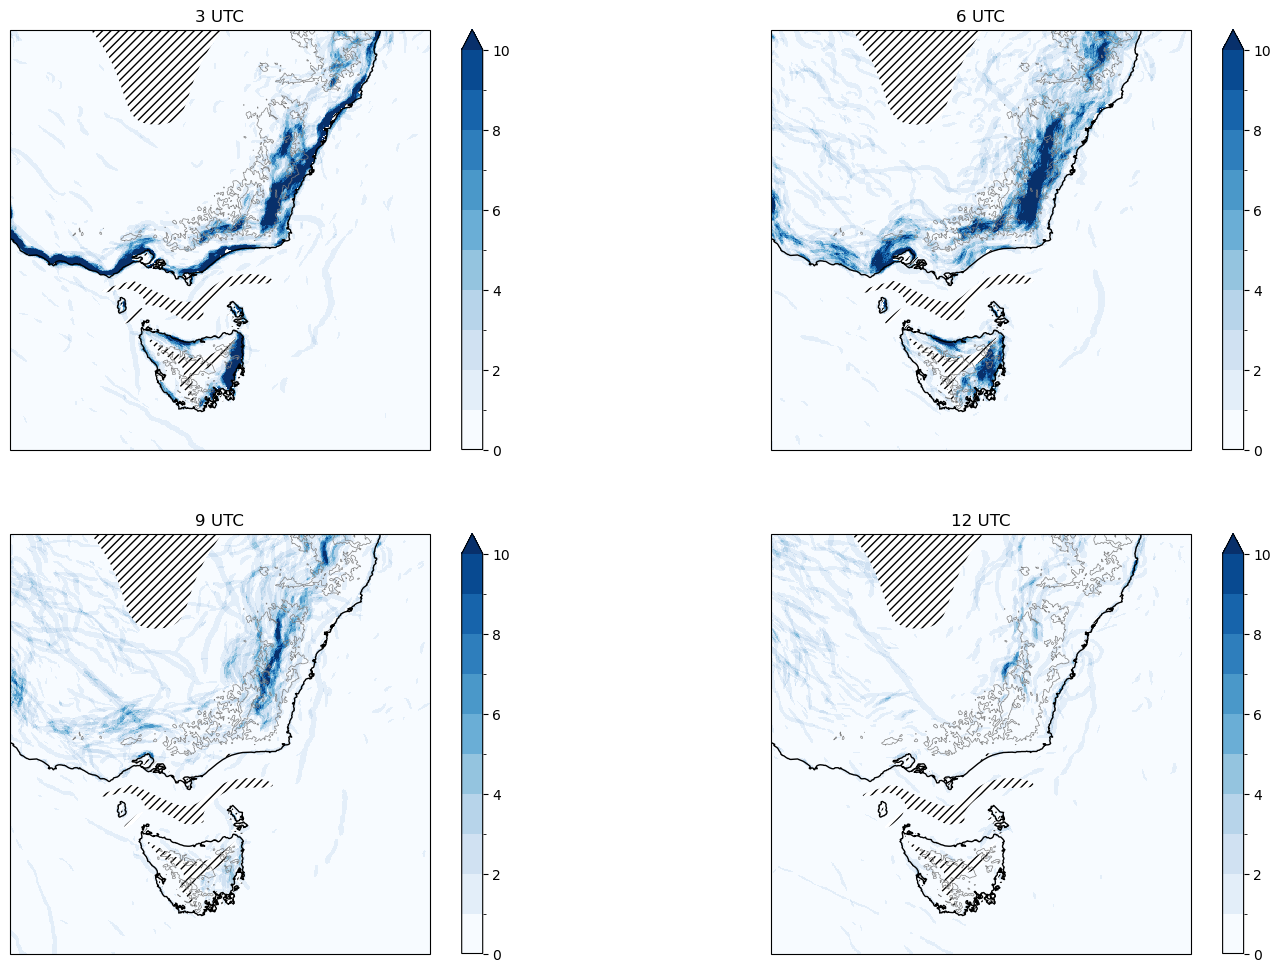

In [7]:
plt.figure(figsize=[18,12])

lat_slice=seaus_lat
lon_slice=seaus_lon
orog, lsm = load_model_data.load_aus2200_static("mjo-elnino2016",lon_slice,lat_slice)

ax=plt.subplot(2,2,1,projection=ccrs.PlateCarree())
mask(
    F_list[0].mask.sel(lat=lat_slice,lon=lon_slice,time=F_list[0].time.dt.hour==3).sum("time"),
    angle_list[0].sel(lat=lat_slice,lon=lon_slice)).plot(cmap="Blues",levels=np.linspace(0,10,11))
ax.coastlines()
xr.plot.contourf(angle_list[0].sel(lat=lat_slice,lon=lon_slice).variance_interp,levels=[0.,0.5],hatches=["","////"],colors="none",add_colorbar=False)
xr.plot.contour(orog,levels=[600,1200],colors=["grey","grey"],linewidths=0.5)
plt.title("3 UTC")

ax=plt.subplot(2,2,2,projection=ccrs.PlateCarree())
mask(
    F_list[0].mask.sel(lat=lat_slice,lon=lon_slice,time=F_list[0].time.dt.hour==6).sum("time"),
    angle_list[0].sel(lat=lat_slice,lon=lon_slice)).plot(cmap="Blues",levels=np.linspace(0,10,11))
ax.coastlines()
xr.plot.contourf(angle_list[0].sel(lat=lat_slice,lon=lon_slice).variance_interp,levels=[0.,0.5],hatches=["","////"],colors="none",add_colorbar=False)
xr.plot.contour(orog,levels=[600,1200],colors=["grey","grey"],linewidths=0.5)
plt.title("6 UTC")

ax=plt.subplot(2,2,3,projection=ccrs.PlateCarree())
mask(
    F_list[0].mask.sel(lat=lat_slice,lon=lon_slice,time=F_list[0].time.dt.hour==9).sum("time"),
    angle_list[0].sel(lat=lat_slice,lon=lon_slice)).plot(cmap="Blues",levels=np.linspace(0,10,11))
ax.coastlines()
xr.plot.contourf(angle_list[0].sel(lat=lat_slice,lon=lon_slice).variance_interp,levels=[0.,0.5],hatches=["","////"],colors="none",add_colorbar=False)
xr.plot.contour(orog,levels=[600,1200],colors=["grey","grey"],linewidths=0.5)
plt.title("9 UTC")

ax=plt.subplot(2,2,4,projection=ccrs.PlateCarree())
mask(
    F_list[0].mask.sel(lat=lat_slice,lon=lon_slice,time=F_list[0].time.dt.hour==12).sum("time"),
    angle_list[0].sel(lat=lat_slice,lon=lon_slice)).plot(cmap="Blues",levels=np.linspace(0,10,11))
ax.coastlines()
xr.plot.contourf(angle_list[0].sel(lat=lat_slice,lon=lon_slice).variance_interp,levels=[0.,0.5],hatches=["","////"],colors="none",add_colorbar=False)
xr.plot.contour(orog,levels=[600,1200],colors=["grey","grey"],linewidths=0.5)
plt.title("12 UTC")

Text(0.5, 1.0, '12 UTC')

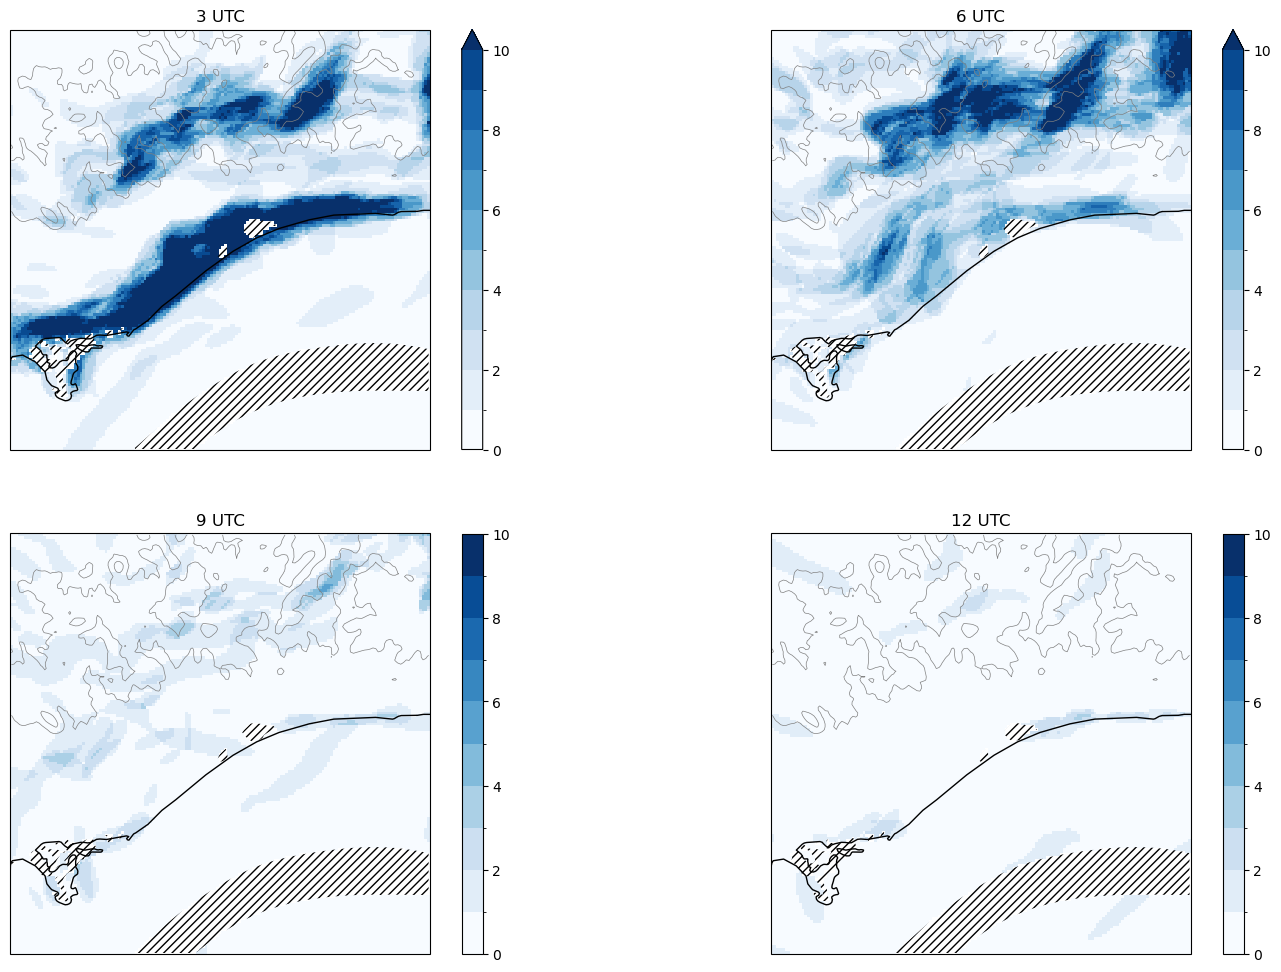

In [38]:
plt.figure(figsize=[18,12])

lat_slice=gipps_lat
lon_slice=gipps_lon
orog, lsm = load_model_data.load_aus2200_static("mjo-elnino2016",lon_slice,lat_slice)

ax=plt.subplot(2,2,1,projection=ccrs.PlateCarree())
mask(
    F_list[0].mask.sel(lat=lat_slice,lon=lon_slice,time=F_list[0].time.dt.hour==3).sum("time"),
    angle_list[0].sel(lat=lat_slice,lon=lon_slice)).plot(cmap="Blues",levels=np.linspace(0,10,11))
ax.coastlines()
xr.plot.contourf(angle_list[0].sel(lat=lat_slice,lon=lon_slice).variance_interp,levels=[0.,0.5],hatches=["","////"],colors="none",add_colorbar=False)
xr.plot.contour(orog,levels=[600,1200],colors=["grey","grey"],linewidths=0.5)
plt.title("3 UTC")

ax=plt.subplot(2,2,2,projection=ccrs.PlateCarree())
mask(
    F_list[0].mask.sel(lat=lat_slice,lon=lon_slice,time=F_list[0].time.dt.hour==6).sum("time"),
    angle_list[0].sel(lat=lat_slice,lon=lon_slice)).plot(cmap="Blues",levels=np.linspace(0,10,11))
ax.coastlines()
xr.plot.contourf(angle_list[0].sel(lat=lat_slice,lon=lon_slice).variance_interp,levels=[0.,0.5],hatches=["","////"],colors="none",add_colorbar=False)
xr.plot.contour(orog,levels=[600,1200],colors=["grey","grey"],linewidths=0.5)
plt.title("6 UTC")

ax=plt.subplot(2,2,3,projection=ccrs.PlateCarree())
mask(
    F_list[0].mask.sel(lat=lat_slice,lon=lon_slice,time=F_list[0].time.dt.hour==9).sum("time"),
    angle_list[0].sel(lat=lat_slice,lon=lon_slice)).plot(cmap="Blues",levels=np.linspace(0,10,11))
ax.coastlines()
xr.plot.contourf(angle_list[0].sel(lat=lat_slice,lon=lon_slice).variance_interp,levels=[0.,0.5],hatches=["","////"],colors="none",add_colorbar=False)
xr.plot.contour(orog,levels=[600,1200],colors=["grey","grey"],linewidths=0.5)
plt.title("9 UTC")

ax=plt.subplot(2,2,4,projection=ccrs.PlateCarree())
mask(
    F_list[0].mask.sel(lat=lat_slice,lon=lon_slice,time=F_list[0].time.dt.hour==12).sum("time"),
    angle_list[0].sel(lat=lat_slice,lon=lon_slice)).plot(cmap="Blues",levels=np.linspace(0,10,11))
ax.coastlines()
xr.plot.contourf(angle_list[0].sel(lat=lat_slice,lon=lon_slice).variance_interp,levels=[0.,0.5],hatches=["","////"],colors="none",add_colorbar=False)
xr.plot.contour(orog,levels=[600,1200],colors=["grey","grey"],linewidths=0.5)
plt.title("12 UTC")

Text(0.5, 1.0, '12 UTC')

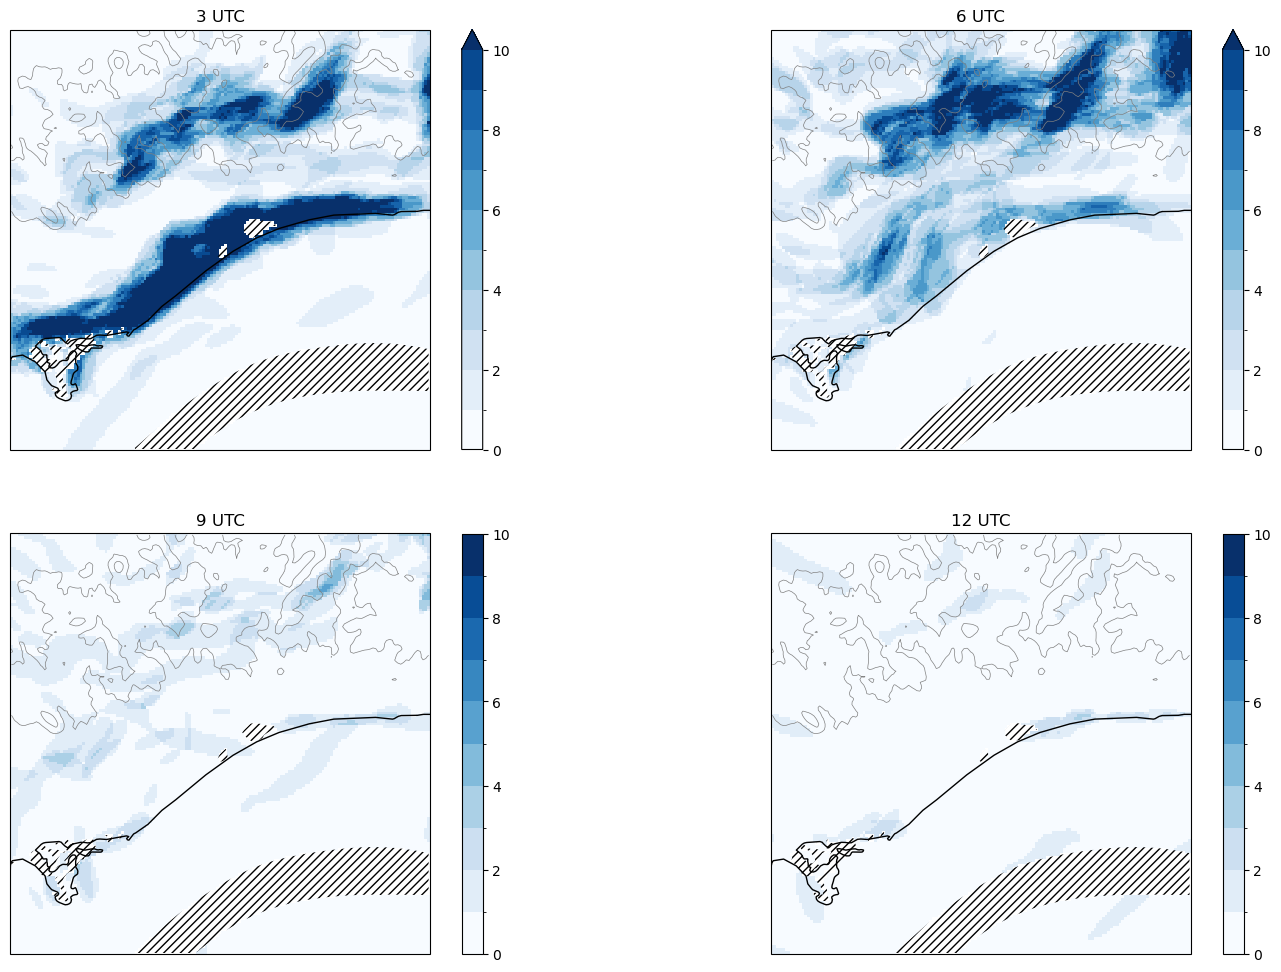

In [38]:
plt.figure(figsize=[18,12])

lat_slice=gipps_lat
lon_slice=gipps_lon
orog, lsm = load_model_data.load_aus2200_static("mjo-elnino2016",lon_slice,lat_slice)

ax=plt.subplot(2,2,1,projection=ccrs.PlateCarree())
mask(
    F_list[0].mask.sel(lat=lat_slice,lon=lon_slice,time=F_list[0].time.dt.hour==3).sum("time"),
    angle_list[0].sel(lat=lat_slice,lon=lon_slice)).plot(cmap="Blues",levels=np.linspace(0,10,11))
ax.coastlines()
xr.plot.contourf(angle_list[0].sel(lat=lat_slice,lon=lon_slice).variance_interp,levels=[0.,0.5],hatches=["","////"],colors="none",add_colorbar=False)
xr.plot.contour(orog,levels=[600,1200],colors=["grey","grey"],linewidths=0.5)
plt.title("3 UTC")

ax=plt.subplot(2,2,2,projection=ccrs.PlateCarree())
mask(
    F_list[0].mask.sel(lat=lat_slice,lon=lon_slice,time=F_list[0].time.dt.hour==6).sum("time"),
    angle_list[0].sel(lat=lat_slice,lon=lon_slice)).plot(cmap="Blues",levels=np.linspace(0,10,11))
ax.coastlines()
xr.plot.contourf(angle_list[0].sel(lat=lat_slice,lon=lon_slice).variance_interp,levels=[0.,0.5],hatches=["","////"],colors="none",add_colorbar=False)
xr.plot.contour(orog,levels=[600,1200],colors=["grey","grey"],linewidths=0.5)
plt.title("6 UTC")

ax=plt.subplot(2,2,3,projection=ccrs.PlateCarree())
mask(
    F_list[0].mask.sel(lat=lat_slice,lon=lon_slice,time=F_list[0].time.dt.hour==9).sum("time"),
    angle_list[0].sel(lat=lat_slice,lon=lon_slice)).plot(cmap="Blues",levels=np.linspace(0,10,11))
ax.coastlines()
xr.plot.contourf(angle_list[0].sel(lat=lat_slice,lon=lon_slice).variance_interp,levels=[0.,0.5],hatches=["","////"],colors="none",add_colorbar=False)
xr.plot.contour(orog,levels=[600,1200],colors=["grey","grey"],linewidths=0.5)
plt.title("9 UTC")

ax=plt.subplot(2,2,4,projection=ccrs.PlateCarree())
mask(
    F_list[0].mask.sel(lat=lat_slice,lon=lon_slice,time=F_list[0].time.dt.hour==12).sum("time"),
    angle_list[0].sel(lat=lat_slice,lon=lon_slice)).plot(cmap="Blues",levels=np.linspace(0,10,11))
ax.coastlines()
xr.plot.contourf(angle_list[0].sel(lat=lat_slice,lon=lon_slice).variance_interp,levels=[0.,0.5],hatches=["","////"],colors="none",add_colorbar=False)
xr.plot.contour(orog,levels=[600,1200],colors=["grey","grey"],linewidths=0.5)
plt.title("12 UTC")

Text(0.5, 1.0, '12 UTC')

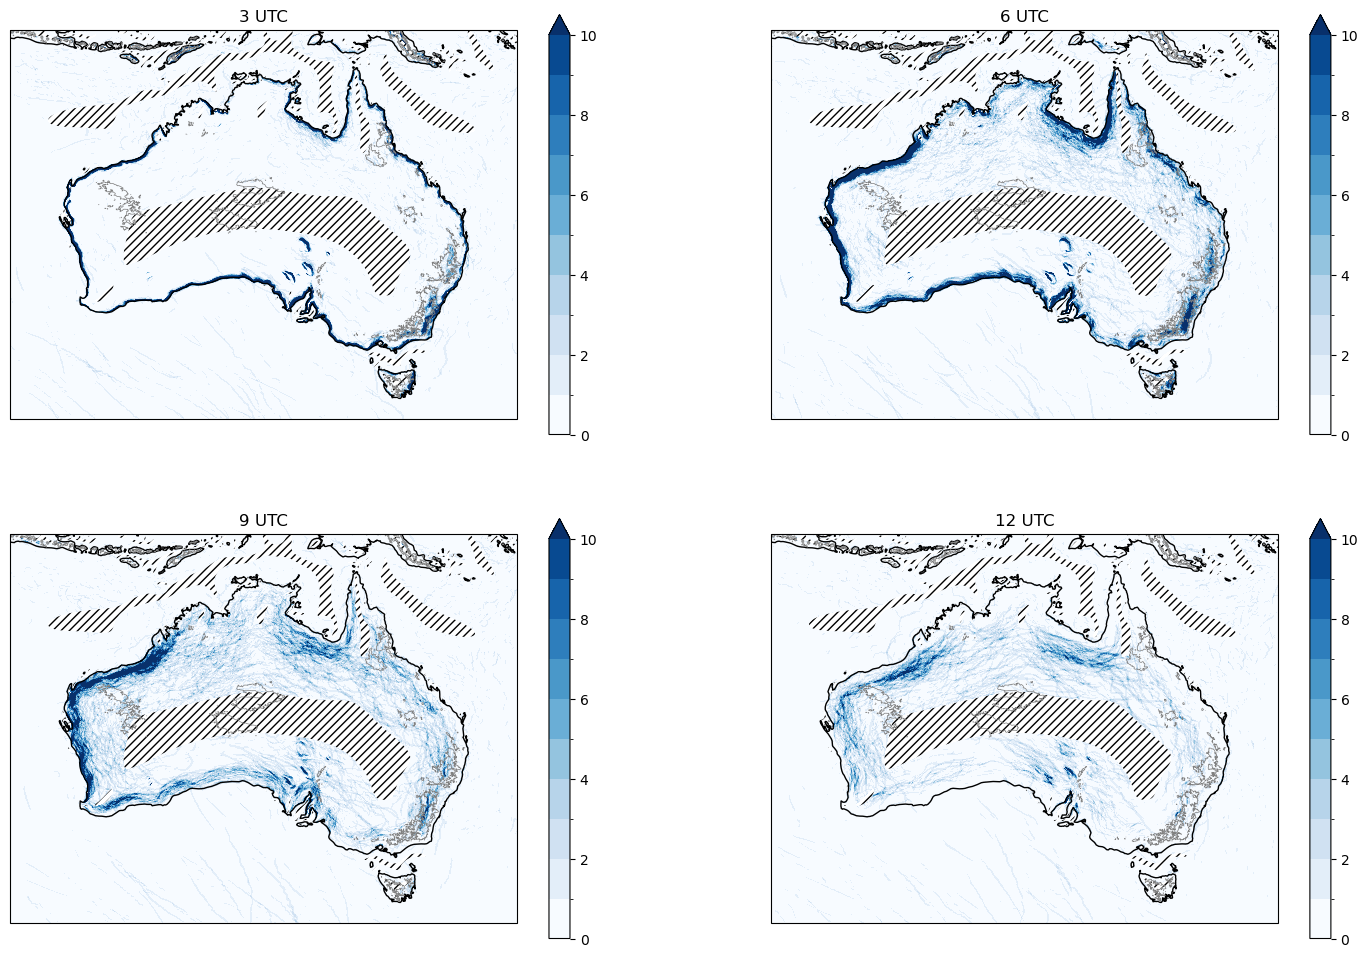

In [40]:
plt.figure(figsize=[18,12])

lat_slice=aus_lat
lon_slice=aus_lon
orog, lsm = load_model_data.load_aus2200_static("mjo-elnino2016",lon_slice,lat_slice)

ax=plt.subplot(2,2,1,projection=ccrs.PlateCarree())
mask(
    F_list[0].mask.sel(lat=lat_slice,lon=lon_slice,time=F_list[0].time.dt.hour==3).sum("time"),
    angle_list[0].sel(lat=lat_slice,lon=lon_slice)).plot(cmap="Blues",levels=np.linspace(0,10,11))
ax.coastlines()
xr.plot.contourf(angle_list[0].sel(lat=lat_slice,lon=lon_slice).variance_interp,levels=[0.,0.5],hatches=["","////"],colors="none",add_colorbar=False)
xr.plot.contour(orog,levels=[600,1200],colors=["grey","grey"],linewidths=0.5)
plt.title("3 UTC")

ax=plt.subplot(2,2,2,projection=ccrs.PlateCarree())
mask(
    F_list[0].mask.sel(lat=lat_slice,lon=lon_slice,time=F_list[0].time.dt.hour==6).sum("time"),
    angle_list[0].sel(lat=lat_slice,lon=lon_slice)).plot(cmap="Blues",levels=np.linspace(0,10,11))
ax.coastlines()
xr.plot.contourf(angle_list[0].sel(lat=lat_slice,lon=lon_slice).variance_interp,levels=[0.,0.5],hatches=["","////"],colors="none",add_colorbar=False)
xr.plot.contour(orog,levels=[600,1200],colors=["grey","grey"],linewidths=0.5)
plt.title("6 UTC")

ax=plt.subplot(2,2,3,projection=ccrs.PlateCarree())
mask(
    F_list[0].mask.sel(lat=lat_slice,lon=lon_slice,time=F_list[0].time.dt.hour==9).sum("time"),
    angle_list[0].sel(lat=lat_slice,lon=lon_slice)).plot(cmap="Blues",levels=np.linspace(0,10,11))
ax.coastlines()
xr.plot.contourf(angle_list[0].sel(lat=lat_slice,lon=lon_slice).variance_interp,levels=[0.,0.5],hatches=["","////"],colors="none",add_colorbar=False)
xr.plot.contour(orog,levels=[600,1200],colors=["grey","grey"],linewidths=0.5)
plt.title("9 UTC")

ax=plt.subplot(2,2,4,projection=ccrs.PlateCarree())
mask(
    F_list[0].mask.sel(lat=lat_slice,lon=lon_slice,time=F_list[0].time.dt.hour==12).sum("time"),
    angle_list[0].sel(lat=lat_slice,lon=lon_slice)).plot(cmap="Blues",levels=np.linspace(0,10,11))
ax.coastlines()
xr.plot.contourf(angle_list[0].sel(lat=lat_slice,lon=lon_slice).variance_interp,levels=[0.,0.5],hatches=["","////"],colors="none",add_colorbar=False)
xr.plot.contour(orog,levels=[600,1200],colors=["grey","grey"],linewidths=0.5)
plt.title("12 UTC")

# Diurnal timing at each grid point (SBI)

Text(0.5, 1.0, '12 UTC')

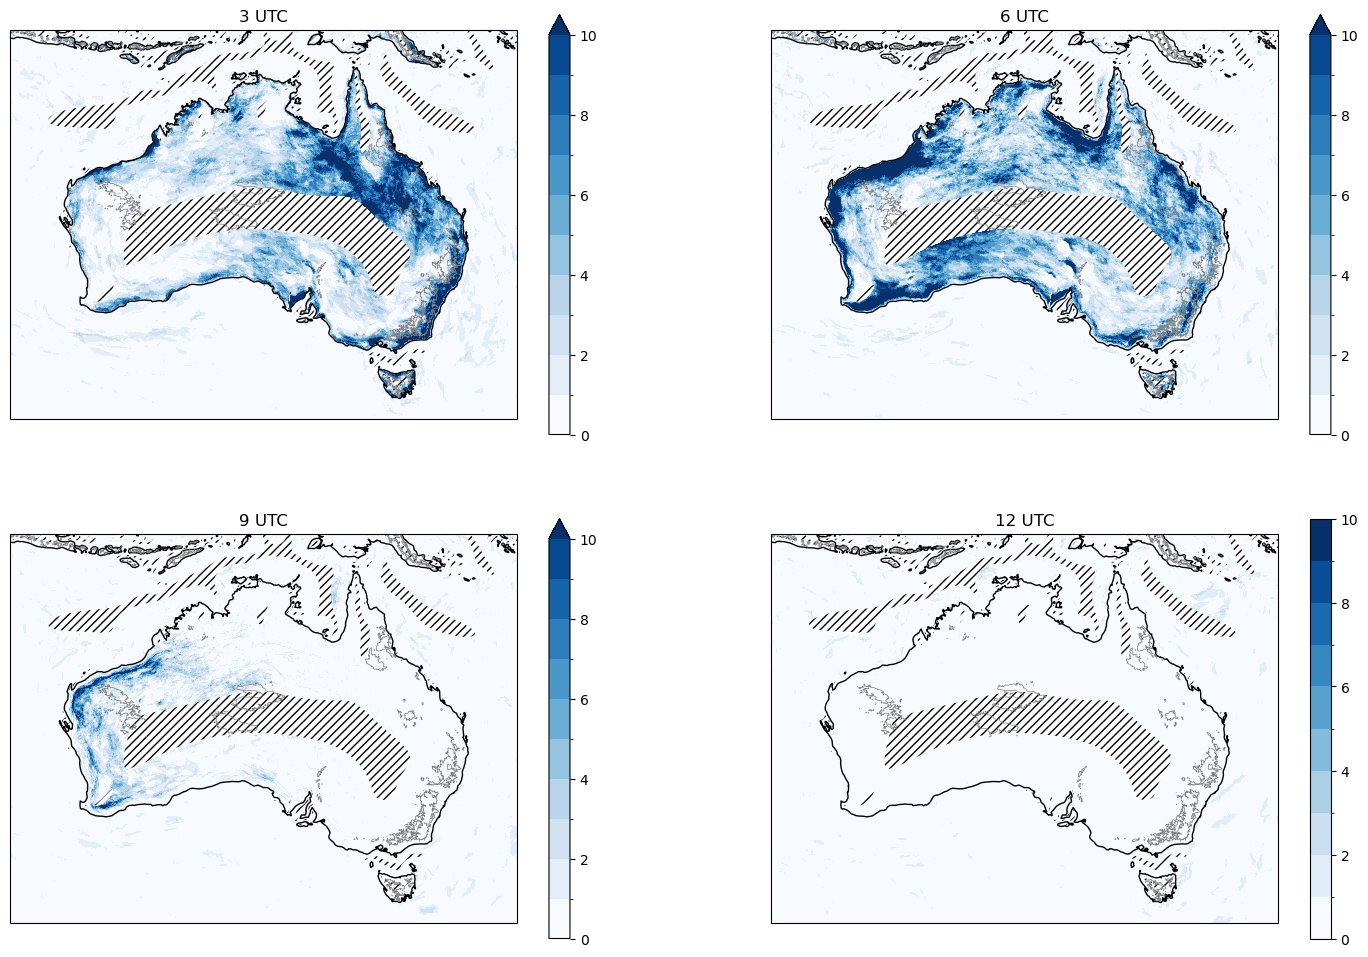

In [8]:
plt.figure(figsize=[18,12])

lat_slice=aus_lat
lon_slice=aus_lon
orog, lsm = load_model_data.load_aus2200_static("mjo-elnino2016",lon_slice,lat_slice)

ax=plt.subplot(2,2,1,projection=ccrs.PlateCarree())
mask(
    sbi_list[0].mask.sel(lat=lat_slice,lon=lon_slice,time=sbi_list[0].time.dt.hour==3).sum("time"),
    angle_list[0].sel(lat=lat_slice,lon=lon_slice)).plot(cmap="Blues",levels=np.linspace(0,10,11))
ax.coastlines()
xr.plot.contourf(angle_list[0].sel(lat=lat_slice,lon=lon_slice).variance_interp,levels=[0.,0.5],hatches=["","////"],colors="none",add_colorbar=False)
xr.plot.contour(orog,levels=[600,1200],colors=["grey","grey"],linewidths=0.5)
plt.title("3 UTC")

ax=plt.subplot(2,2,2,projection=ccrs.PlateCarree())
mask(
    sbi_list[0].mask.sel(lat=lat_slice,lon=lon_slice,time=sbi_list[0].time.dt.hour==6).sum("time"),
    angle_list[0].sel(lat=lat_slice,lon=lon_slice)).plot(cmap="Blues",levels=np.linspace(0,10,11))
ax.coastlines()
xr.plot.contourf(angle_list[0].sel(lat=lat_slice,lon=lon_slice).variance_interp,levels=[0.,0.5],hatches=["","////"],colors="none",add_colorbar=False)
xr.plot.contour(orog,levels=[600,1200],colors=["grey","grey"],linewidths=0.5)
plt.title("6 UTC")

ax=plt.subplot(2,2,3,projection=ccrs.PlateCarree())
mask(
    sbi_list[0].mask.sel(lat=lat_slice,lon=lon_slice,time=sbi_list[0].time.dt.hour==9).sum("time"),
    angle_list[0].sel(lat=lat_slice,lon=lon_slice)).plot(cmap="Blues",levels=np.linspace(0,10,11))
ax.coastlines()
xr.plot.contourf(angle_list[0].sel(lat=lat_slice,lon=lon_slice).variance_interp,levels=[0.,0.5],hatches=["","////"],colors="none",add_colorbar=False)
xr.plot.contour(orog,levels=[600,1200],colors=["grey","grey"],linewidths=0.5)
plt.title("9 UTC")

ax=plt.subplot(2,2,4,projection=ccrs.PlateCarree())
mask(
    sbi_list[0].mask.sel(lat=lat_slice,lon=lon_slice,time=sbi_list[0].time.dt.hour==12).sum("time"),
    angle_list[0].sel(lat=lat_slice,lon=lon_slice)).plot(cmap="Blues",levels=np.linspace(0,10,11))
ax.coastlines()
xr.plot.contourf(angle_list[0].sel(lat=lat_slice,lon=lon_slice).variance_interp,levels=[0.,0.5],hatches=["","////"],colors="none",add_colorbar=False)
xr.plot.contour(orog,levels=[600,1200],colors=["grey","grey"],linewidths=0.5)
plt.title("12 UTC")

# Total sea breeze hours (comparison of different methods)

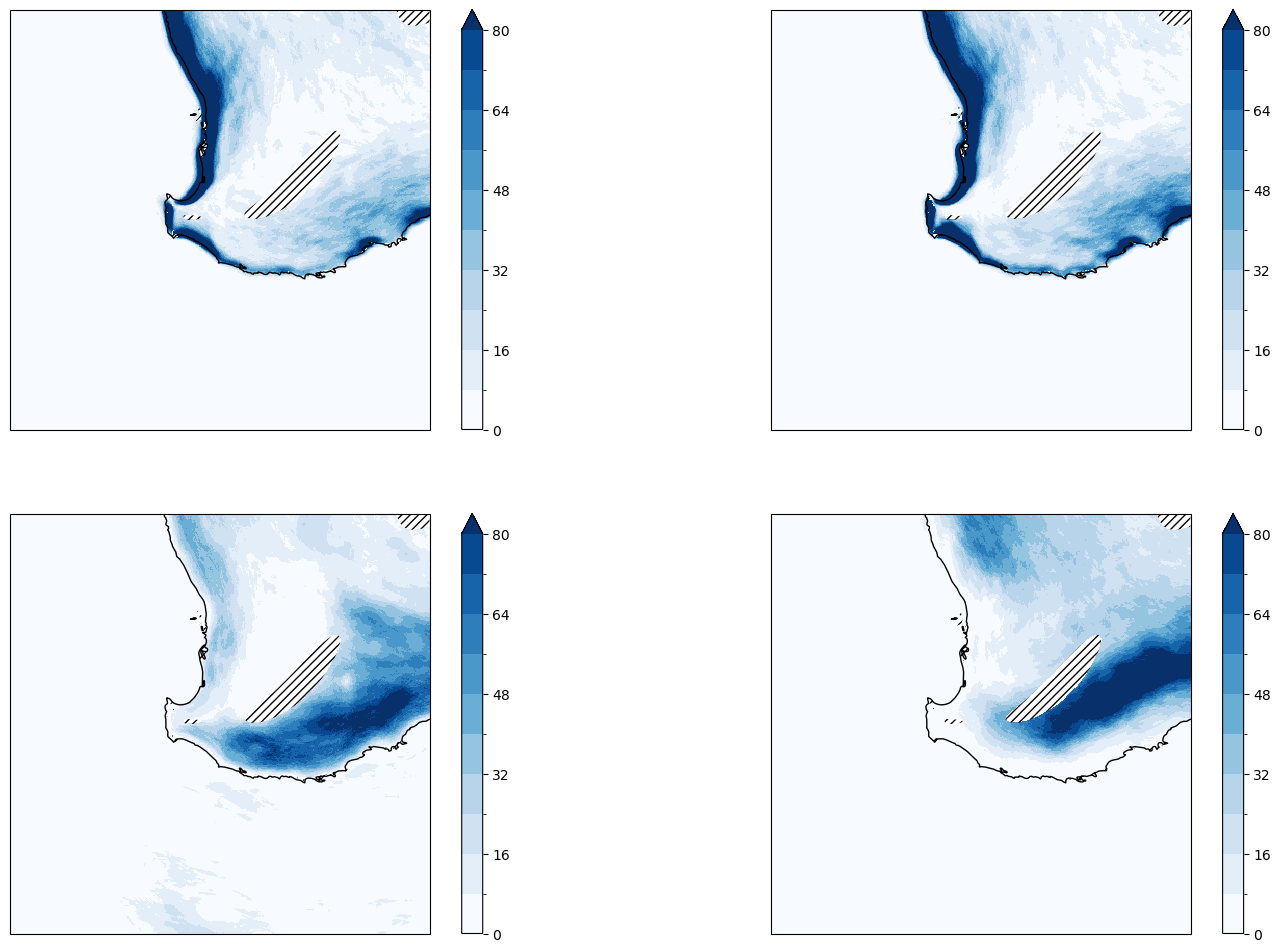

In [41]:
lat_slice=large_perth_lat
lon_slice=large_perth_lon

plt.figure(figsize=[18,12])

ax=plt.subplot(2,2,1,projection=ccrs.PlateCarree())
mask(
    F_list[0].mask.sel(lat=lat_slice,lon=lon_slice).sum("time"),
    angle_list[0].sel(lat=lat_slice,lon=lon_slice)).plot(cmap="Blues",levels=np.linspace(0,80,11))
ax.coastlines()
xr.plot.contourf(angle_list[0].sel(lat=lat_slice,lon=lon_slice).variance_interp,levels=[0.,0.5],hatches=["","////"],colors="none",add_colorbar=False)

ax=plt.subplot(2,2,2,projection=ccrs.PlateCarree())
mask(
    Fc_list[0].mask.sel(lat=lat_slice,lon=lon_slice).sum("time"),
    angle_list[0].sel(lat=lat_slice,lon=lon_slice)).plot(cmap="Blues",levels=np.linspace(0,80,11))
ax.coastlines()
xr.plot.contourf(angle_list[0].sel(lat=lat_slice,lon=lon_slice).variance_interp,levels=[0.,0.5],hatches=["","////"],colors="none",add_colorbar=False)

ax=plt.subplot(2,2,3,projection=ccrs.PlateCarree())
mask(
    sbi_list[0].mask.sel(lat=lat_slice,lon=lon_slice).sum("time"),
    angle_list[0].sel(lat=lat_slice,lon=lon_slice)).plot(cmap="Blues",levels=np.linspace(0,80,11))
ax.coastlines()
xr.plot.contourf(angle_list[0].sel(lat=lat_slice,lon=lon_slice).variance_interp,levels=[0.,0.5],hatches=["","////"],colors="none",add_colorbar=False)

ax=plt.subplot(2,2,4,projection=ccrs.PlateCarree())
mask(
    fuzzy_list[0].mask.sel(lat=lat_slice,lon=lon_slice).sum("time"),
    angle_list[0].sel(lat=lat_slice,lon=lon_slice)).plot(cmap="Blues",levels=np.linspace(0,80,11))
ax.coastlines()
xr.plot.contourf(angle_list[0].sel(lat=lat_slice,lon=lon_slice).variance_interp,levels=[0.,0.5],hatches=["","////"],colors="none",add_colorbar=False)


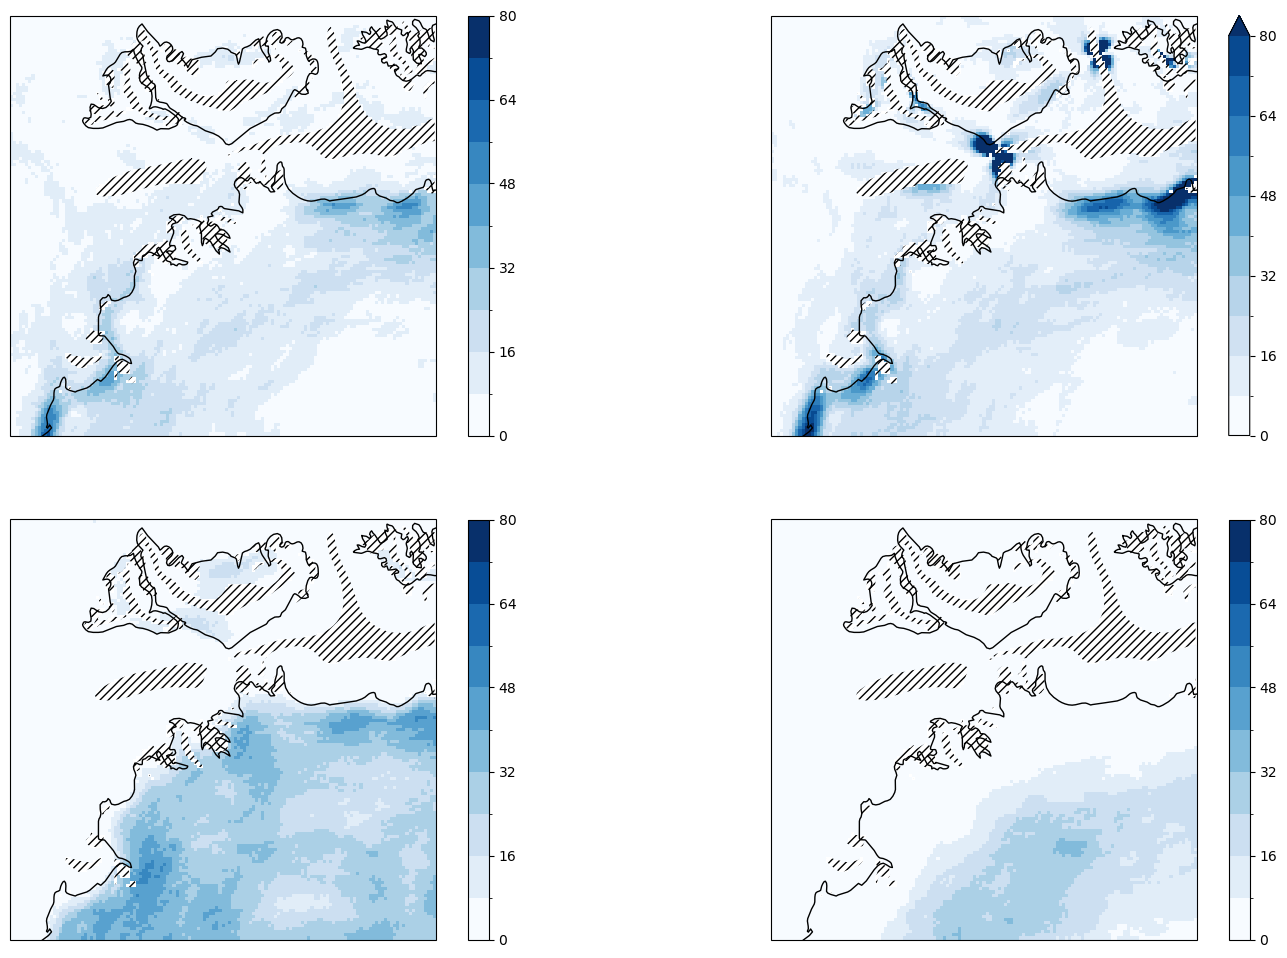

In [43]:
lat_slice=darwin_lat
lon_slice=darwin_lon
orog, lsm = load_model_data.load_aus2200_static("mjo-elnino2016",lon_slice,lat_slice)

plt.figure(figsize=[18,12])

ax=plt.subplot(2,2,1,projection=ccrs.PlateCarree())
mask(
    F_list[0].mask.sel(lat=lat_slice,lon=lon_slice).sum("time"),
    angle_list[0].sel(lat=lat_slice,lon=lon_slice)).plot(cmap="Blues",levels=np.linspace(0,80,11))
ax.coastlines()
xr.plot.contourf(angle_list[0].sel(lat=lat_slice,lon=lon_slice).variance_interp,levels=[0.,0.5],hatches=["","////"],colors="none",add_colorbar=False)
xr.plot.contour(orog,levels=[600,1200],colors=["grey","grey"],linewidths=0.5)

ax=plt.subplot(2,2,2,projection=ccrs.PlateCarree())
mask(
    Fc_list[0].mask.sel(lat=lat_slice,lon=lon_slice).sum("time"),
    angle_list[0].sel(lat=lat_slice,lon=lon_slice)).plot(cmap="Blues",levels=np.linspace(0,80,11))
ax.coastlines()
xr.plot.contourf(angle_list[0].sel(lat=lat_slice,lon=lon_slice).variance_interp,levels=[0.,0.5],hatches=["","////"],colors="none",add_colorbar=False)
xr.plot.contour(orog,levels=[600,1200],colors=["grey","grey"],linewidths=0.5)

ax=plt.subplot(2,2,3,projection=ccrs.PlateCarree())
mask(
    sbi_list[0].mask.sel(lat=lat_slice,lon=lon_slice).sum("time"),
    angle_list[0].sel(lat=lat_slice,lon=lon_slice)).plot(cmap="Blues",levels=np.linspace(0,80,11))
ax.coastlines()
xr.plot.contourf(angle_list[0].sel(lat=lat_slice,lon=lon_slice).variance_interp,levels=[0.,0.5],hatches=["","////"],colors="none",add_colorbar=False)
xr.plot.contour(orog,levels=[600,1200],colors=["grey","grey"],linewidths=0.5)

ax=plt.subplot(2,2,4,projection=ccrs.PlateCarree())
mask(
    fuzzy_list[0].mask.sel(lat=lat_slice,lon=lon_slice).sum("time"),
    angle_list[0].sel(lat=lat_slice,lon=lon_slice)).plot(cmap="Blues",levels=np.linspace(0,80,11))
ax.coastlines()
xr.plot.contourf(angle_list[0].sel(lat=lat_slice,lon=lon_slice).variance_interp,levels=[0.,0.5],hatches=["","////"],colors="none",add_colorbar=False)
xr.plot.contour(orog,levels=[600,1200],colors=["grey","grey"],linewidths=0.5)

# Map of number of sea breeze hours, with diurnal cycle of unique sea breeze objects in each region (comparison of methods)

Text(0, 0.5, 'Total number of sea breeze objects')

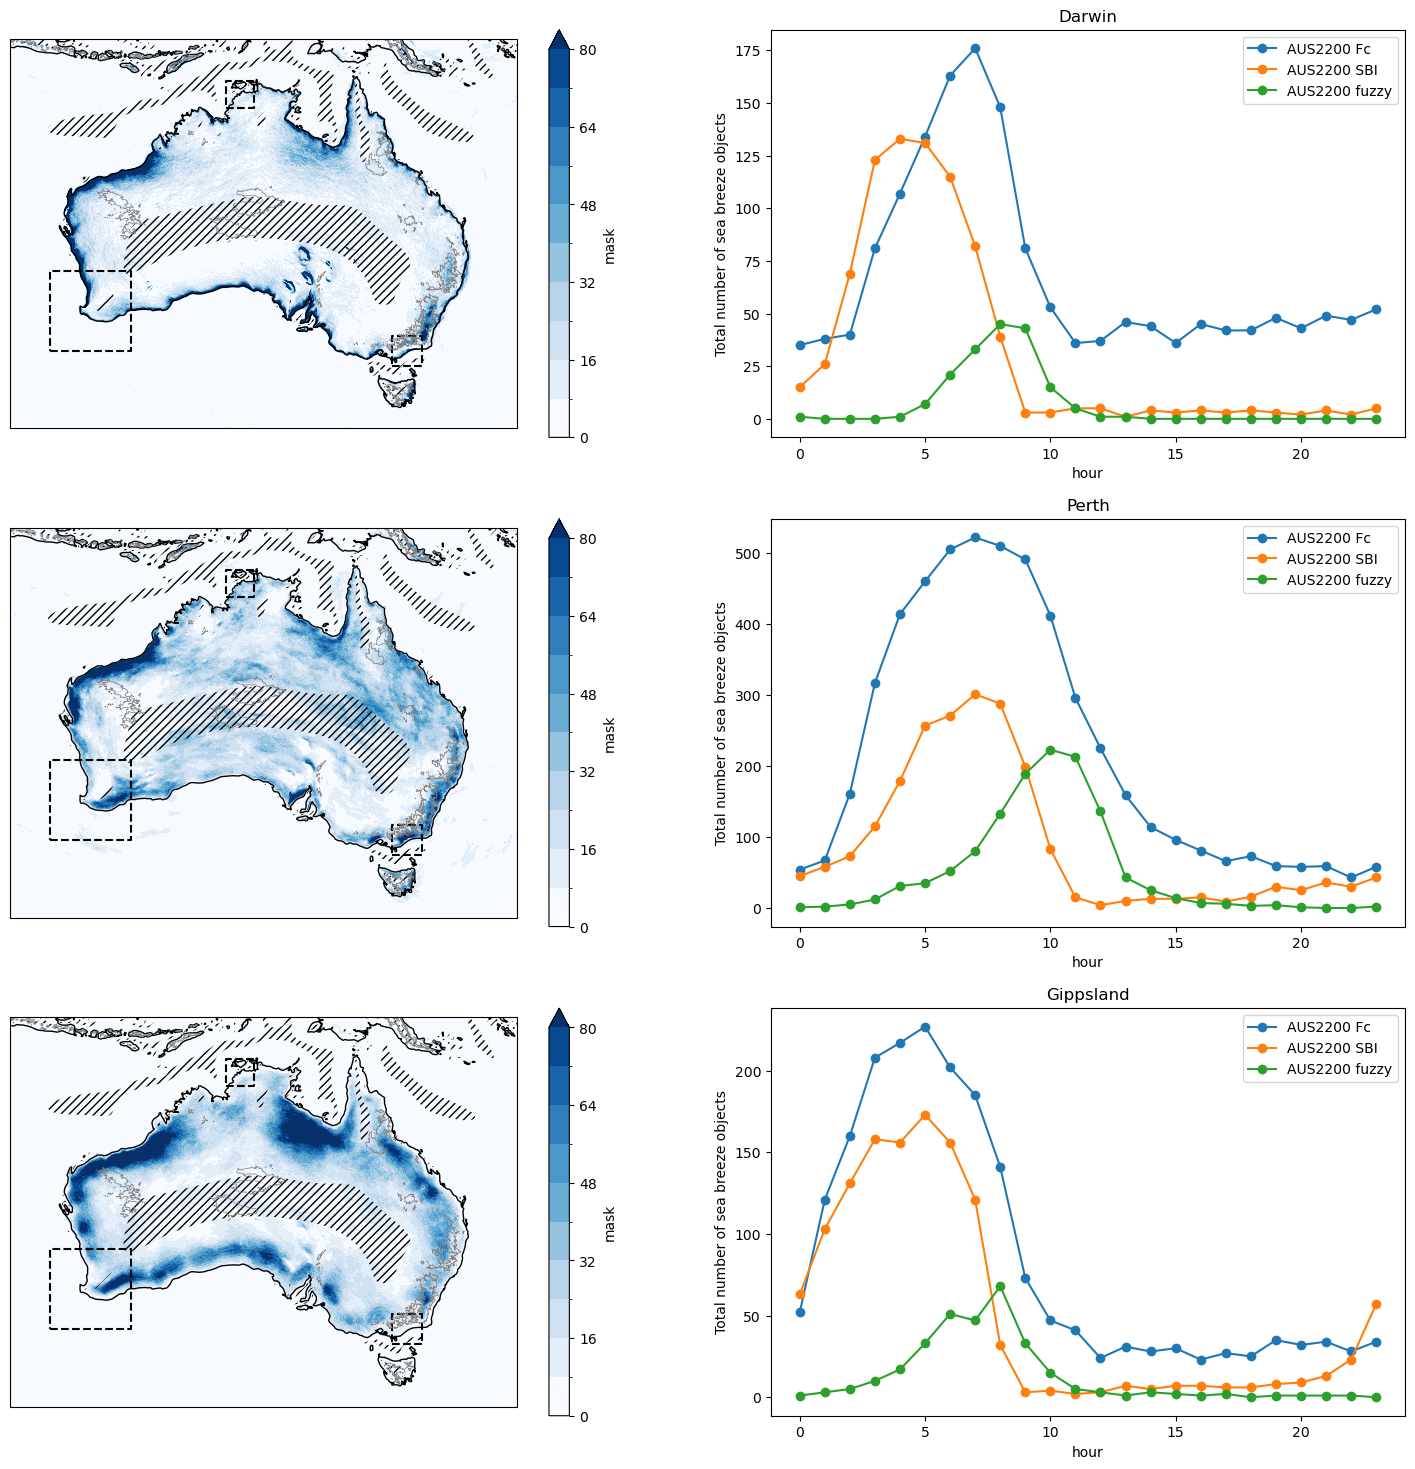

In [45]:
def draw_boxes(lon_slice,lat_slice):

    plt.plot([lon_slice.start,lon_slice.stop,lon_slice.stop,lon_slice.start,lon_slice.start],
             [lat_slice.start,lat_slice.start,lat_slice.stop,lat_slice.stop,lat_slice.start],
             color="k",ls="--")    


plt.figure(figsize=[18,18])

orog, lsm = load_model_data.load_aus2200_static("mjo-elnino2016",aus_lon,aus_lat)

ax=plt.subplot(3,2,1,projection=ccrs.PlateCarree())
F_list[0].mask.sum("time").plot(cmap="Blues",levels=np.linspace(0,80,11))
draw_boxes(large_perth_lon,large_perth_lat)
draw_boxes(darwin_lon,darwin_lat)
draw_boxes(gipps_lon,gipps_lat)
xr.plot.contourf(angle_list[0].variance_interp,levels=[0.,0.5],hatches=["","////"],colors="none",add_colorbar=False)
ax.coastlines()
xr.plot.contour(orog,levels=[600,1200],colors=["grey","grey"],linewidths=0.5)

ax=plt.subplot(3,2,3,projection=ccrs.PlateCarree())
sbi_list[0].mask.sum("time").plot(cmap="Blues",levels=np.linspace(0,80,11))
draw_boxes(large_perth_lon,large_perth_lat)
draw_boxes(darwin_lon,darwin_lat)
draw_boxes(gipps_lon,gipps_lat)
xr.plot.contourf(angle_list[0].variance_interp,levels=[0.,0.5],hatches=["","////"],colors="none",add_colorbar=False)
ax.coastlines()
xr.plot.contour(orog,levels=[600,1200],colors=["grey","grey"],linewidths=0.5)

ax=plt.subplot(3,2,5,projection=ccrs.PlateCarree())
fuzzy_list[0].mask.sum("time").plot(cmap="Blues",levels=np.linspace(0,80,11))
draw_boxes(large_perth_lon,large_perth_lat)
draw_boxes(darwin_lon,darwin_lat)
draw_boxes(gipps_lon,gipps_lat)
xr.plot.contourf(angle_list[0].variance_interp,levels=[0.,0.5],hatches=["","////"],colors="none",add_colorbar=False)
ax.coastlines()
xr.plot.contour(orog,levels=[600,1200],colors=["grey","grey"],linewidths=0.5)

ax=plt.subplot(3,2,2)
# Fc_list[0].mask.sel(lat=darwin_lat,lon=darwin_lon).mean(("lat","lon")).groupby("time.hour").mean().plot(label="AUS2200 Fc",marker="o")
# sbi_list[0].mask.sel(lat=darwin_lat,lon=darwin_lon).mean(("lat","lon")).groupby("time.hour").mean().plot(label="AUS2200 SBI",marker="o")
# fuzzy_list[0].mask.sel(lat=darwin_lat,lon=darwin_lon).mean(("lat","lon")).groupby("time.hour").mean().plot(label="AUS2200 fuzzy",marker="o")
#Fc_list[0].sel(lat=darwin_lat,lon=darwin_lon).max(("lat","lon")).groupby("time.hour").sum().plot(label="AUS2200 Fc",marker="o")
#sbi_list[0].sel(lat=darwin_lat,lon=darwin_lon).max(("lat","lon")).groupby("time.hour").sum().plot(label="AUS2200 SBI",marker="o")
#fuzzy_list[0].sel(lat=darwin_lat,lon=darwin_lon).max(("lat","lon")).groupby("time.hour").sum().plot(label="AUS2200 fuzzy",marker="o")
xr.apply_ufunc(
    count_num_of_objs,
    mask(F_list[0].filtered_labels.sel(lat=darwin_lat,lon=darwin_lon),angle_list[0].sel(lat=darwin_lat,lon=darwin_lon)),
    input_core_dims=[["lat","lon"]],
    dask="parallelized",
    vectorize=True).groupby("time.hour").sum().plot(label="AUS2200 Fc",marker="o")
xr.apply_ufunc(
    count_num_of_objs,
    mask(sbi_list[0].filtered_labels.sel(lat=darwin_lat,lon=darwin_lon),angle_list[0].sel(lat=darwin_lat,lon=darwin_lon)),
    input_core_dims=[["lat","lon"]],
    dask="parallelized",
    vectorize=True).groupby("time.hour").sum().plot(label="AUS2200 SBI",marker="o")
xr.apply_ufunc(
    count_num_of_objs,
    mask(fuzzy_list[0].filtered_labels.sel(lat=darwin_lat,lon=darwin_lon),angle_list[0].sel(lat=darwin_lat,lon=darwin_lon)),
    input_core_dims=[["lat","lon"]],
    dask="parallelized",
    vectorize=True).groupby("time.hour").sum().plot(label="AUS2200 fuzzy",marker="o")
plt.legend()
plt.title("Darwin")
plt.ylabel("Total number of sea breeze objects")

ax=plt.subplot(3,2,4)
xr.apply_ufunc(
    count_num_of_objs,
    mask(F_list[0].filtered_labels.sel(lat=large_perth_lat,lon=large_perth_lon),angle_list[0].sel(lat=large_perth_lat,lon=large_perth_lon)),
    input_core_dims=[["lat","lon"]],
    dask="parallelized",
    vectorize=True).groupby("time.hour").sum().plot(label="AUS2200 Fc",marker="o")
xr.apply_ufunc(
    count_num_of_objs,
    mask(sbi_list[0].filtered_labels.sel(lat=large_perth_lat,lon=large_perth_lon),angle_list[0].sel(lat=large_perth_lat,lon=large_perth_lon)),
    input_core_dims=[["lat","lon"]],
    dask="parallelized",
    vectorize=True).groupby("time.hour").sum().plot(label="AUS2200 SBI",marker="o")
xr.apply_ufunc(
    count_num_of_objs,
    mask(fuzzy_list[0].filtered_labels.sel(lat=large_perth_lat,lon=large_perth_lon),angle_list[0].sel(lat=large_perth_lat,lon=large_perth_lon)),
    input_core_dims=[["lat","lon"]],
    dask="parallelized",
    vectorize=True).groupby("time.hour").sum().plot(label="AUS2200 fuzzy",marker="o")
plt.legend()
plt.title("Perth")
plt.ylabel("Total number of sea breeze objects")

ax=plt.subplot(3,2,6)
xr.apply_ufunc(
    count_num_of_objs,
    mask(F_list[0].filtered_labels.sel(lat=gipps_lat,lon=gipps_lon),angle_list[0].sel(lat=gipps_lat,lon=gipps_lon)),
    input_core_dims=[["lat","lon"]],
    dask="parallelized",
    vectorize=True).groupby("time.hour").sum().plot(label="AUS2200 Fc",marker="o")
xr.apply_ufunc(
    count_num_of_objs,
    mask(sbi_list[0].filtered_labels.sel(lat=gipps_lat,lon=gipps_lon),angle_list[0].sel(lat=gipps_lat,lon=gipps_lon)),
    input_core_dims=[["lat","lon"]],
    dask="parallelized",
    vectorize=True).groupby("time.hour").sum().plot(label="AUS2200 SBI",marker="o")
xr.apply_ufunc(
    count_num_of_objs,
    mask(fuzzy_list[0].filtered_labels.sel(lat=gipps_lat,lon=gipps_lon),angle_list[0].sel(lat=gipps_lat,lon=gipps_lon)),
    input_core_dims=[["lat","lon"]],
    dask="parallelized",
    vectorize=True).groupby("time.hour").sum().plot(label="AUS2200 fuzzy",marker="o")
plt.legend()
plt.title("Gippsland")
plt.ylabel("Total number of sea breeze objects")


# Map of diurnal max in sea breeze objects (comparison between methods)

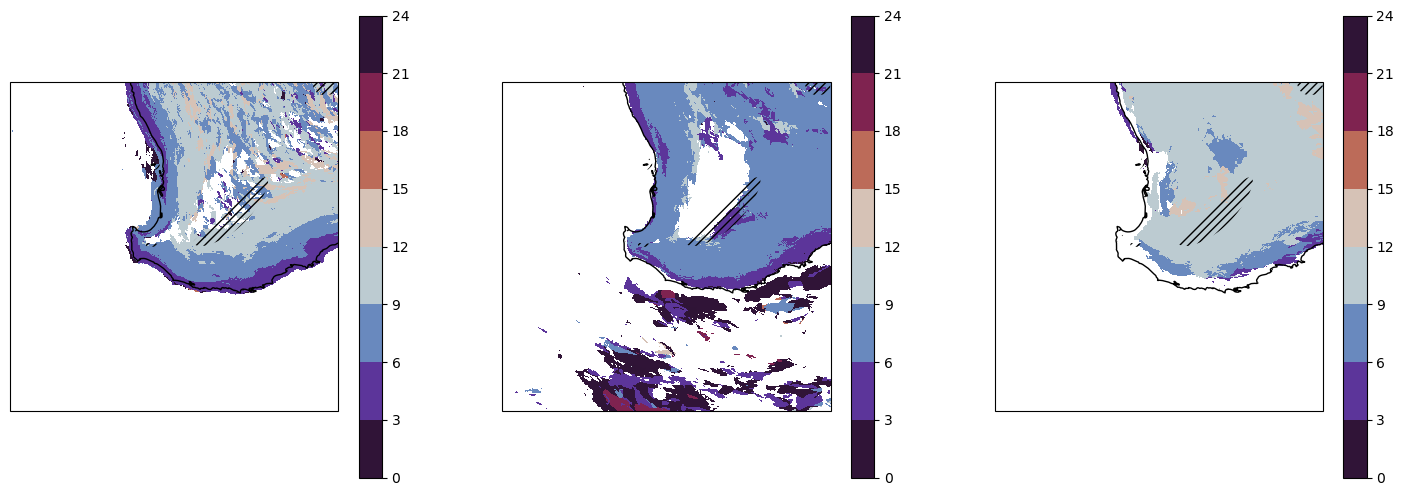

In [7]:
orog, lsm = load_model_data.load_aus2200_static("mjo-elnino2016",large_perth_lon,large_perth_lat)

plt.figure(figsize=[18,6])

ax=plt.subplot(1,3,1,projection=ccrs.PlateCarree())
da = Fc_list[0].mask.sel(lat=large_perth_lat, lon=large_perth_lon)
xr.where(da.sum("time") >= 5,
         da.groupby("time.hour").sum().idxmax("hour"),
         np.nan).plot(cmap="twilight_shifted",levels=np.arange(0,27,3))
xr.plot.contourf(angle_list[0].variance_interp.sel(lat=large_perth_lat, lon=large_perth_lon),levels=[0.,0.5],hatches=["","////"],colors="none",add_colorbar=False)
ax.coastlines()
xr.plot.contour(orog,levels=[600,1200],colors=["grey","grey"],linewidths=0.5)

ax=plt.subplot(1,3,2,projection=ccrs.PlateCarree())
da = sbi_list[0].mask.sel(lat=large_perth_lat, lon=large_perth_lon)
xr.where(da.sum("time") >= 5,
         da.groupby("time.hour").sum().idxmax("hour"),
         np.nan).plot(cmap="twilight_shifted",levels=np.arange(0,27,3))
xr.plot.contourf(angle_list[0].variance_interp.sel(lat=large_perth_lat, lon=large_perth_lon),levels=[0.,0.5],hatches=["","////"],colors="none",add_colorbar=False)
ax.coastlines()
xr.plot.contour(orog,levels=[600,1200],colors=["grey","grey"],linewidths=0.5)

ax=plt.subplot(1,3,3,projection=ccrs.PlateCarree())
da = fuzzy_list[0].mask.sel(lat=large_perth_lat, lon=large_perth_lon)
xr.where(da.sum("time") >= 5,
         da.groupby("time.hour").sum().idxmax("hour"),
         np.nan).plot(cmap="twilight_shifted",levels=np.arange(0,27,3))
xr.plot.contourf(angle_list[0].variance_interp.sel(lat=large_perth_lat, lon=large_perth_lon),levels=[0.,0.5],hatches=["","////"],colors="none",add_colorbar=False)
ax.coastlines()
xr.plot.contour(orog,levels=[600,1200],colors=["grey","grey"],linewidths=0.5)


In [17]:
def calc_hourly_max(da,min_hours):

    hour_counts = da.groupby("time.hour").sum()
    hour_max = hour_counts.argmax("hour")
    hour_max_masked = xr.where(da.sum("time") >= min_hours, hour_max, np.nan)

    return hour_max_masked

min_hours=5
fc_hour_max_masked = calc_hourly_max(Fc_list[0].mask.chunk({"time":-1,"lon":100,"lat":100}),min_hours).persist()
sbi_hour_max_masked = calc_hourly_max(sbi_list[0].mask.chunk({"time":-1,"lon":100,"lat":100}),min_hours).persist()
fuzzy_hour_max_masked = calc_hourly_max(fuzzy_list[0].mask.chunk({"time":-1,"lon":100,"lat":100}),min_hours).persist()


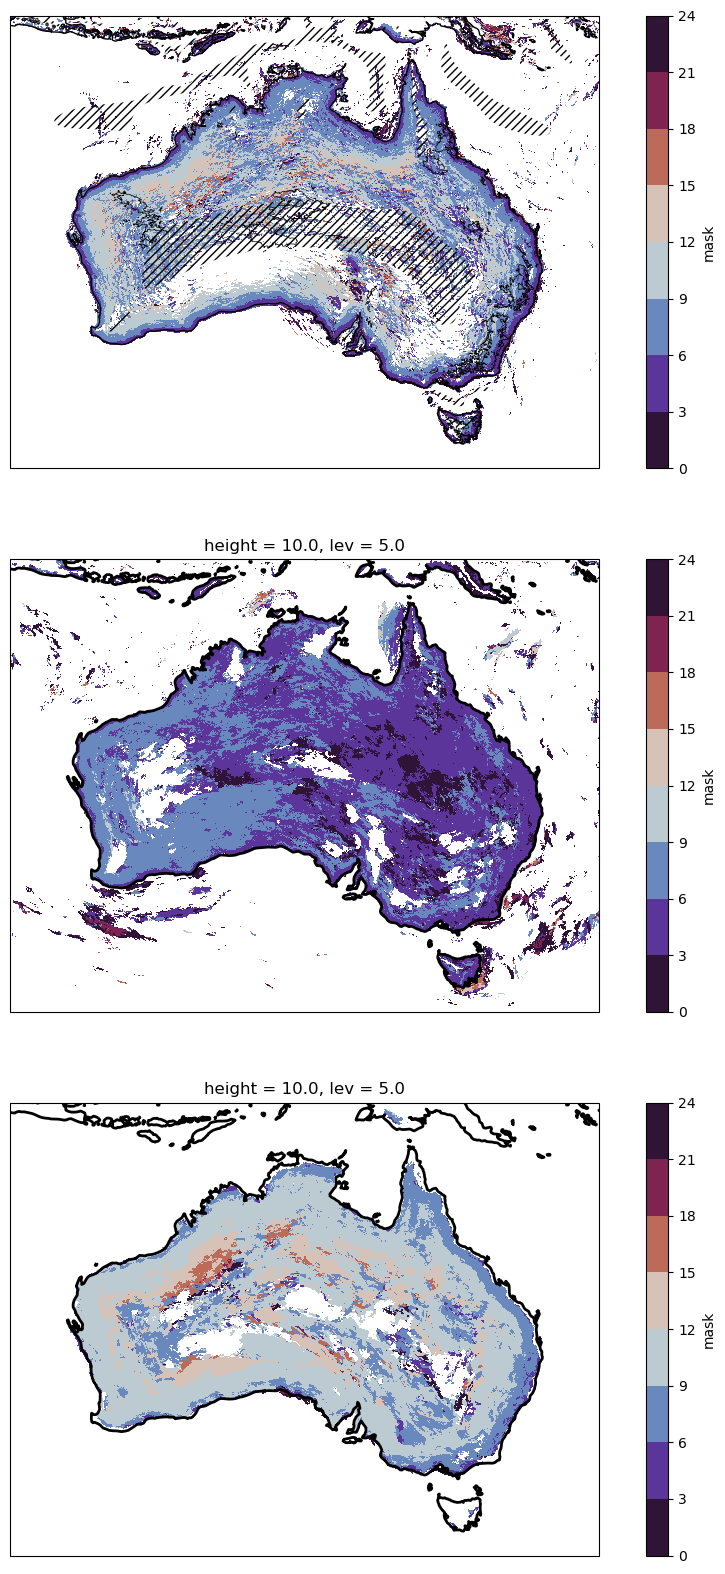

In [18]:
plt.figure(figsize=[12,20])

orog, lsm = load_model_data.load_aus2200_static("mjo-elnino2016",aus_lon,aus_lat)

ax=plt.subplot(3,1,1,projection=ccrs.PlateCarree())
fc_hour_max_masked.plot(cmap="twilight_shifted",levels=np.arange(0,27,3))
xr.plot.contourf(angle_list[0].variance_interp,levels=[0.,0.5],hatches=["","////"],colors="none",add_colorbar=False)
ax.coastlines()
xr.plot.contour(orog,levels=[600,1200],colors=["k","k"],linewidths=0.5)

ax=plt.subplot(3,1,2,projection=ccrs.PlateCarree())
sbi_hour_max_masked.plot(cmap="twilight_shifted",levels=np.arange(0,27,3))
xr.plot.contourf(angle_list[0].variance_interp,levels=[0.,0.5],hatches=["","////"],colors="none",add_colorbar=False)
ax.coastlines()
xr.plot.contour(orog,levels=[600,1200],colors=["k","k"],linewidths=0.5)

ax=plt.subplot(3,1,3,projection=ccrs.PlateCarree())
fuzzy_hour_max_masked.plot(cmap="twilight_shifted",levels=np.arange(0,27,3))
xr.plot.contourf(angle_list[0].variance_interp,levels=[0.,0.5],hatches=["","////"],colors="none",add_colorbar=False)
ax.coastlines()
xr.plot.contour(orog,levels=[600,1200],colors=["k","k"],linewidths=0.5)